In [1]:
# Thư viện hệ thống
import os
import time
import json

# Xử lý dữ liệu và toán học
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Vẽ đồ thị
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow và Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

2025-06-19 04:32:22.481652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750307542.695273      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750307542.756737      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# Cấu hình
IMG_SIZE = 224
BATCH_SIZE = 128
PRETRAIN_EPOCHS = 30
FINETUNE_EPOCHS = 35
LEARNING_RATE = 0.001
FINETUNE_LR = 0.0001
EMBEDDING_SIZE = 128

In [4]:
# Đường dẫn dữ liệu
DATA_PATH = "/kaggle/input/face-data-200-augmentation/200"
VAL_PATH = os.path.join(DATA_PATH, "validation")
TRAIN_PATH = "/kaggle/input/train-data-austr/train"
TEST_PATH = os.path.join(DATA_PATH, "test")

In [5]:
# 1. LOAD VÀ XỬ LÝ DỮ LIỆU
def load_images_and_labels(data_path):
    """Load ảnh và nhãn từ thư mục"""
    images = []
    labels = []
    student_names = []
    
    for student_folder in os.listdir(data_path):
        student_path = os.path.join(data_path, student_folder)
        if os.path.isdir(student_path):
            student_names.append(student_folder)
            
            for img_file in os.listdir(student_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(student_path, img_file)
                    
                    # Đọc và resize ảnh
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        img = img.astype(np.float32) / 255.0
                        
                        images.append(img)
                        labels.append(student_folder)
    
    return np.array(images), np.array(labels), list(set(student_names))

In [6]:
print("Đang load dữ liệu training...")
train_images, train_labels, student_names = load_images_and_labels(TRAIN_PATH)

print("Đang load dữ liệu validation...")
val_images, val_labels, _ = load_images_and_labels(VAL_PATH)

print("Đang load dữ liệu test...")
test_images, test_labels, _ = load_images_and_labels(TEST_PATH)

print(f"Training: {len(train_images)} ảnh")
print(f"Validation: {len(val_images)} ảnh")
print(f"Test: {len(test_images)} ảnh")
print(f"Số sinh viên: {len(student_names)}")

Đang load dữ liệu training...
Đang load dữ liệu validation...
Đang load dữ liệu test...
Training: 6614 ảnh
Validation: 806 ảnh
Test: 670 ảnh
Số sinh viên: 24


In [7]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)
print(f"Số lớp (classes): {num_classes}")

Số lớp (classes): 24


In [8]:
# 2. TẠO MÔ HÌNH MOBILENETV2 VỚI ARCFACE
class ArcFaceLayer(tf.keras.layers.Layer):
    """ArcFace Loss Layer"""
    
    def __init__(self, num_classes, embedding_size=128, margin=0.4, scale=30, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(self.embedding_size, self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )
        super(ArcFaceLayer, self).build(input_shape)
    
    def call(self, inputs, training=None):
        embeddings, labels = inputs
        
        # Normalize embeddings và weights
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)
        W_normalized = tf.nn.l2_normalize(self.W, axis=0)
        
        # Tính cosine similarity
        cos_theta = tf.matmul(embeddings, W_normalized)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        
        if training:
            # Áp dụng ArcFace margin
            theta = tf.acos(cos_theta)
            labels_one_hot = tf.one_hot(tf.cast(labels, tf.int32), self.num_classes)
            theta_margin = theta + self.margin * labels_one_hot
            cos_theta_margin = tf.cos(theta_margin)
            output = cos_theta_margin * self.scale
        else:
            output = cos_theta * self.scale
            
        return output

In [9]:
def create_models(num_classes, embedding_size=128):
    """
    Tạo 2 models:
    - training_model: Để train với ArcFace loss (input: image + label)
    - inference_model: Để extract embedding (input: chỉ image)
    """
    
    # Base model MobileNetV2
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Input layers
    image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
    label_input = tf.keras.Input(shape=(), dtype=tf.int32, name='label_input')
    
    # Feature extraction
    x = base_model(image_input, training=True)
    x = GlobalAveragePooling2D()(x)

    # Block 1: Feature extraction
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001), name='dense_1024')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    # kernel_regularizer=l2(0.001)
    
    # Block 2: Feature refinement
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001), name='feature_layer')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    
    # Block 3: Classification preparation
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001), name='dense_256')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    # Embedding layer
    embeddings = Dense(embedding_size, activation=None, name='embeddings')(x)
    
    # ArcFace layer cho training
    arcface_output = ArcFaceLayer(num_classes, embedding_size, name='arcface')(
        [embeddings, label_input]
    )
    
    # TRAINING MODEL: Có 2 inputs (image + label) -> ArcFace output
    training_model = Model(
        inputs=[image_input, label_input], 
        outputs=arcface_output,
        name='training_model'
    )
    
    # INFERENCE MODEL: Chỉ có 1 input (image) -> embedding output
    inference_model = Model(
        inputs=image_input, 
        outputs=embeddings,
        name='inference_model'
    )
    
    return training_model, inference_model, base_model

In [10]:
# Tạo models
print("Đang tạo mô hình...")
training_model, inference_model, base_model = create_models(num_classes, EMBEDDING_SIZE)

Đang tạo mô hình...


I0000 00:00:1750307632.867032      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750307632.867676      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
print(f"\n=== TRAINING MODEL (dùng để train) ===")
print("Input: [image, label] -> Output: ArcFace logits")
training_model.summary()


=== TRAINING MODEL (dùng để train) ===
Input: [image, label] -> Output: ArcFace logits


Model: "training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ image_input[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1024 (Dense)        │ (None, 1024)           │      1,311,744 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1024)           │          4,096 │ dense_1024[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ feature_layer (Dense)     │ (None, 512)            │        524,800 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512)            │          2,048 │ feature_layer[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_256 (Dense)         │ (None, 256)            │        131,328 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dense_256[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings (Dense)        │ (None, 128)            │         32,896 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ arcface (ArcFaceLayer)    │ (None, 24)             │          3,072 │ embeddings[0][0],      │
│                           │                        │                │ label_input[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,268,992 (16.28 MB)

 Trainable params: 4,231,296 (16.14 MB)

 Non-trainable params: 37,696 (147.25 KB)

In [12]:
print(f"\n=== INFERENCE MODEL (dùng để extract embedding) ===") 
print("Input: image -> Output: embedding vector")
inference_model.summary()


=== INFERENCE MODEL (dùng để extract embedding) ===
Input: image -> Output: embedding vector


Model: "inference_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1024 (Dense)                   │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embeddings (Dense)                   │ (None, 128)                 │          32,896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,265,920 (16.27 MB)

 Trainable params: 4,228,224 (16.13 MB)

 Non-trainable params: 37,696 (147.25 KB)

In [13]:
# 3. CHUẨN BỊ DỮ LIỆU
def create_tf_dataset(images, labels, batch_size, shuffle=True):
    """Tạo tf.data.Dataset cho training model (có 2 inputs)"""
    dataset = tf.data.Dataset.from_tensor_slices(({
        'image_input': images,
        'label_input': labels
    }, labels))  # Output vẫn là labels cho loss function
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Tạo datasets
train_dataset = create_tf_dataset(train_images, train_labels_encoded, BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_images, val_labels_encoded, BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(test_images, test_labels_encoded, BATCH_SIZE, shuffle=False)

In [14]:
# import matplotlib.pyplot as plt
# for img_batch, label_batch in val_dataset.take(1):
#     for i in range(5):
#         plt.imshow(img_batch['image_input'][i].numpy())
#         plt.title(f"Val Label: {label_batch[i]}")
#         plt.show()

In [15]:
# 4. PHASE 1: PRETRAIN - Freeze base model
start = time.time()
print("\n" + "="*50)
print("PHASE 1: PRETRAIN - Freeze MobileNetV2 base layers")
print("="*50)

# Freeze tất cả layers của base_model
for layer in base_model.layers:
    layer.trainable = False

# Compile model cho pretrain
training_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks cho pretrain
pretrain_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=6,
        min_delta=0.001,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_pretrain_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Bắt đầu pretrain...")
pretrain_history = training_model.fit(
    train_dataset,
    epochs=PRETRAIN_EPOCHS,
    validation_data=val_dataset,
    callbacks=pretrain_callbacks,
    verbose=1
)

print("✅ Pretrain hoàn thành!")


PHASE 1: PRETRAIN - Freeze MobileNetV2 base layers
Bắt đầu pretrain...
Epoch 1/30


I0000 00:00:1750307658.786321     100 service.cc:148] XLA service 0x78fa20002480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750307658.787567     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750307658.787611     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750307659.898601     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/52 ━━━━━━━━━━━━━━━━━━━━ 20:20 24s/step - accuracy: 0.0000e+00 - loss: 19.8697

I0000 00:00:1750307669.849065     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.1837 - loss: 13.5041
Epoch 1: val_loss improved from inf to 4.79192, saving model to best_pretrain_model.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 48s 463ms/step - accuracy: 0.1828 - loss: 13.5172 - val_accuracy: 0.4553 - val_loss: 4.7919 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.1723 - loss: 12.6380
Epoch 2: val_loss improved from 4.79192 to 2.65715, saving model to best_pretrain_model.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.1736 - loss: 12.6175 - val_accuracy: 0.8722 - val_loss: 2.6572 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2841 - loss: 10.3973
Epoch 3: val_loss improved from 2.65715 to 2.46570, saving model to best_pretrain_model.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.2856 - loss: 10.3760 - val_accuracy: 0.9404 - val_loss: 2.4657 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - 

In [16]:
# 5. PHASE 2: FINETUNE - Unfreeze một số layers
print("\n" + "="*50)
print("PHASE 2: FINETUNE - Unfreeze top layers của MobileNetV2")
print("="*50)

# Unfreeze top layers (20 layers cuối)
for layer in base_model.layers[-20:]:
    layer.trainable = True

print(f"Số layers trainable: {sum([1 for layer in training_model.layers if layer.trainable])}")

# Compile lại với learning rate thấp hơn
training_model.compile(
    optimizer=Adam(learning_rate=FINETUNE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks cho finetune
finetune_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=6,
        min_lr=1e-8,
        min_delta=0.001,
        verbose=1
    ),
    ModelCheckpoint(
        'best_finetune_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("Bắt đầu finetune...")
finetune_history = training_model.fit(
    train_dataset,
    epochs=FINETUNE_EPOCHS,
    validation_data=val_dataset,
    callbacks=finetune_callbacks,
    verbose=1
)

print("✅ Finetune hoàn thành!")
end = time.time()
print(f"Thời gian huấn luyện: {(end - start) / 60} phút")


PHASE 2: FINETUNE - Unfreeze top layers của MobileNetV2
Số layers trainable: 15
Bắt đầu finetune...
Epoch 1/35


E0000 00:00:1750307911.563820      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750307911.712673      99 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7089 - loss: 4.3600

E0000 00:00:1750307927.375261      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750307927.519039      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7093 - loss: 4.3561
Epoch 1: val_loss improved from inf to 1.33650, saving model to best_finetune_model.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 429ms/step - accuracy: 0.7097 - loss: 4.3523 - val_accuracy: 0.9826 - val_loss: 1.3365 - learning_rate: 1.0000e-04
Epoch 2/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8604 - loss: 2.3906
Epoch 2: val_loss improved from 1.33650 to 1.27963, saving model to best_finetune_model.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.8608 - loss: 2.3865 - val_accuracy: 0.9938 - val_loss: 1.2796 - learning_rate: 1.0000e-04
Epoch 3/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9489 - loss: 1.5824
Epoch 3: val_loss improved from 1.27963 to 1.26085, saving model to best_finetune_model.h5
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9488 - loss: 1.5824 - val_accuracy: 0.9963 - val_loss: 1.2608 - learning_rate: 1.0000e-04
Epoch 4/35
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/s

In [17]:
# import json
# import os
# from uuid import uuid4

# # Define hyperparameters
# hyperparameters = {
#     "IMG_SIZE": 224,
#     "BATCH_SIZE": 128,
#     "PRETRAIN_EPOCHS": 40,
#     "FINETUNE_EPOCHS": 80,
#     "LEARNING_RATE": 0.002,
#     "FINETUNE_LR": 0.0002,
#     "EMBEDDING_SIZE": 256,
#     "ARCFACE_MARGIN": 0.15,
#     "ARCFACE_SCALE": 25,
#     "L2_REGULARIZATION": 0.0005,
#     "DROPOUT_RATES": [0.15, 0.1, 0.1],
#     "EarlyStopping patience": 10,
#     "ReduceLROnPlateau factor": 0.5,
#     "ReduceLROnPlateau patience": 6,
#     "FINETUNE_TRAINABLE_LAYERS": 20
# }

# # Function to save training results
# def save_training_results(pretrain_history, finetune_history, filename="training_results.txt"):
#     # Prepare the output data
#     output_data = {
#         "hyperparameters": hyperparameters,
#         "pretrain_results": {
#             "train_loss": pretrain_history.history.get("loss", []),
#             "train_accuracy": pretrain_history.history.get("accuracy", []),
#             "val_loss": pretrain_history.history.get("val_loss", []),
#             "val_accuracy": pretrain_history.history.get("val_accuracy", [])
#         },
#         "finetune_results": {
#             "train_loss": finetune_history.history.get("loss", []),
#             "train_accuracy": finetune_history.history.get("accuracy", []),
#             "val_loss": finetune_history.history.get("val_loss", []),
#             "val_accuracy": finetune_history.history.get("val_accuracy", [])
#         }
#     }
    
#     # Write to file
#     with open(filename, "w") as f:
#         f.write("Training Results\n")
#         f.write("="*50 + "\n\n")
        
#         # Write hyperparameters
#         f.write("Hyperparameters:\n")
#         f.write(json.dumps(hyperparameters, indent=2))
#         f.write("\n\n")
        
#         # Write pretrain results
#         f.write("Pretrain Results:\n")
#         f.write(f"{'Epoch':<10} {'Train Loss':<15} {'Train Acc':<15} {'Val Loss':<15} {'Val Acc':<15}\n")
#         f.write("-"*70 + "\n")
#         for epoch in range(len(output_data["pretrain_results"]["train_loss"])):
#             f.write(f"{epoch+1:<10} "
#                     f"{output_data['pretrain_results']['train_loss'][epoch]:<15.4f} "
#                     f"{output_data['pretrain_results']['train_accuracy'][epoch]:<15.4f} "
#                     f"{output_data['pretrain_results']['val_loss'][epoch]:<15.4f} "
#                     f"{output_data['pretrain_results']['val_accuracy'][epoch]:<15.4f}\n")
#         f.write("\n")
        
#         # Write finetune results
#         f.write("Finetune Results:\n")
#         f.write(f"{'Epoch':<10} {'Train Loss':<15} {'Train Acc':<15} {'Val Loss':<15} {'Val Acc':<15}\n")
#         f.write("-"*70 + "\n")
#         for epoch in range(len(output_data["finetune_results"]["train_loss"])):
#             f.write(f"{epoch+1:<10} "
#                     f"{output_data['finetune_results']['train_loss'][epoch]:<15.4f} "
#                     f"{output_data['finetune_results']['train_accuracy'][epoch]:<15.4f} "
#                     f"{output_data['finetune_results']['val_loss'][epoch]:<15.4f} "
#                     f"{output_data['finetune_results']['val_accuracy'][epoch]:<15.4f}\n")

# # Example usage (add this after your training code)
# save_training_results(pretrain_history, finetune_history, "training_results.txt")

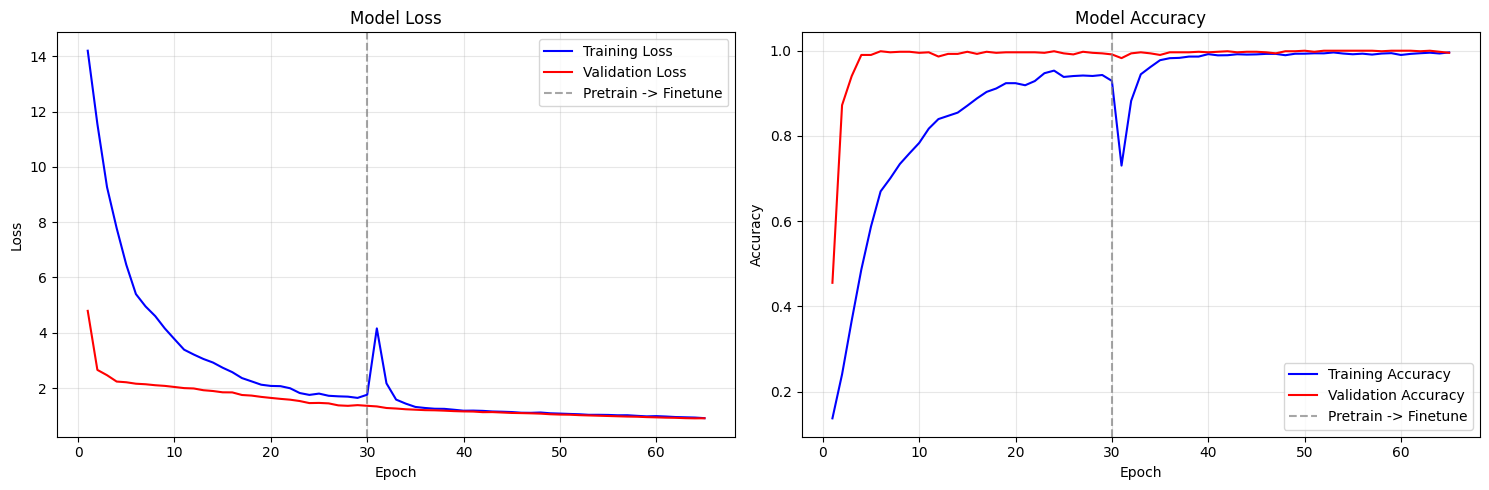

In [18]:
# 6. VẼ BIỂU ĐỒ TRAINING
def plot_training_history(pretrain_hist, finetune_hist):
    """Vẽ biểu đồ quá trình training"""
    
    # Combine histories
    train_loss = pretrain_hist.history['loss'] + finetune_hist.history['loss']
    val_loss = pretrain_hist.history['val_loss'] + finetune_hist.history['val_loss']
    train_acc = pretrain_hist.history['accuracy'] + finetune_hist.history['accuracy']
    val_acc = pretrain_hist.history['val_accuracy'] + finetune_hist.history['val_accuracy']
    
    pretrain_epochs = len(pretrain_hist.history['loss'])
    total_epochs = len(train_loss)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    epochs = range(1, total_epochs + 1)
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.axvline(x=pretrain_epochs, color='gray', linestyle='--', alpha=0.7, label='Pretrain -> Finetune')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    ax2.axvline(x=pretrain_epochs, color='gray', linestyle='--', alpha=0.7, label='Pretrain -> Finetune')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(pretrain_history, finetune_history)

In [19]:
# 7. ĐÁNH GIÁ TRÊN TEST SET
print("\n" + "="*50)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*50)

# Đánh giá với training_model
test_results = training_model.evaluate(test_dataset, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"\n📊 KẾT QUẢ TEST:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


ĐÁNH GIÁ TRÊN TEST SET
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 839ms/step - accuracy: 0.9968 - loss: 0.9301

📊 KẾT QUẢ TEST:
Test Loss: 0.9393
Test Accuracy: 0.9955


In [20]:
# Dự đoán trên test set để tính các metrics khác
print("\nĐang tính toán các metrics chi tiết...")
y_true = []
y_pred = []

for batch_data, batch_labels in test_dataset:
    predictions = training_model.predict(batch_data, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    
    y_true.extend(batch_labels.numpy())
    y_pred.extend(pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)



Đang tính toán các metrics chi tiết...


In [21]:
# 8. TÍNH CÁC METRICS CHI TIẾT
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n📈 CÁC METRICS CHI TIẾT:")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")

# Classification report
print(f"\n📋 CLASSIFICATION REPORT:")
target_names = [f"Student_{name}" for name in label_encoder.classes_]
print(classification_report(y_true, y_pred, target_names=target_names))


📈 CÁC METRICS CHI TIẾT:
Precision (Weighted): 0.9958
Recall (Weighted): 0.9955
F1-Score (Weighted): 0.9955

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

Student_A001       1.00      1.00      1.00        26
Student_A002       1.00      1.00      1.00        29
Student_A003       1.00      1.00      1.00        28
Student_A004       1.00      1.00      1.00        28
Student_A005       1.00      1.00      1.00        28
Student_A006       1.00      1.00      1.00        28
Student_A007       1.00      1.00      1.00        28
Student_A008       1.00      1.00      1.00        28
Student_A009       1.00      0.96      0.98        27
Student_A010       1.00      1.00      1.00        28
Student_A011       1.00      1.00      1.00        28
Student_A012       1.00      0.93      0.96        28
Student_A013       1.00      1.00      1.00        28
Student_A014       1.00      1.00      1.00        28
Student_A015       1.00      1.00      1.00        28
S


🔍 MA TRẬN NHẦM LẪN:


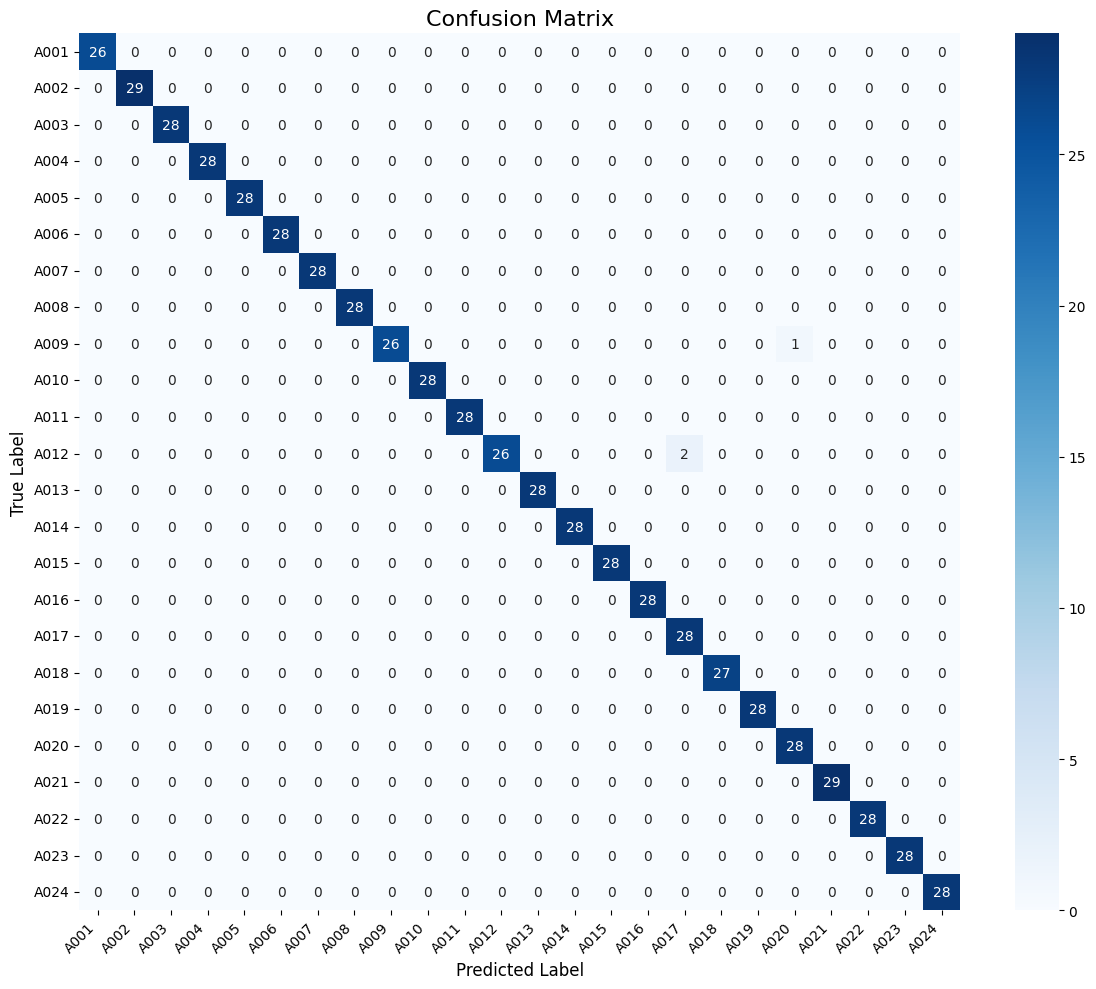

In [22]:
# 9. VẼ CONFUSION MATRIX
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Vẽ ma trận nhầm lẫn"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

print(f"\n🔍 MA TRẬN NHẦM LẪN:")
confusion_matrix_result = plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)

In [23]:
# Tính accuracy per class
print(f"\n📊 ACCURACY CHO TỪNG LỚP:")
class_accuracies = confusion_matrix_result.diagonal() / confusion_matrix_result.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(label_encoder.classes_, class_accuracies)):
    print(f"{class_name}: {acc:.4f}")


📊 ACCURACY CHO TỪNG LỚP:
A001: 1.0000
A002: 1.0000
A003: 1.0000
A004: 1.0000
A005: 1.0000
A006: 1.0000
A007: 1.0000
A008: 1.0000
A009: 0.9630
A010: 1.0000
A011: 1.0000
A012: 0.9286
A013: 1.0000
A014: 1.0000
A015: 1.0000
A016: 1.0000
A017: 1.0000
A018: 1.0000
A019: 1.0000
A020: 1.0000
A021: 1.0000
A022: 1.0000
A023: 1.0000
A024: 1.0000


In [24]:
# Chạy đoạn mã này trên Kaggle
import tensorflow as tf
print(tf.__version__)  # Xác nhận 2.18.0
# # Lưu training model
print(f"\n💾 LƯU MÔ HÌNH...")

# Lưu training model
training_model.save('face_recognition_training_model.h5')

# Lưu inference model (quan trọng nhất cho deployment)
inference_model.save('face_recognition_inference_model.h5')
# training_model.save('face_recognition_training_model.h5')

# # Lưu inference model (quan trọng nhất cho deployment)
# inference_model.save('face_recognition_inference_model.h5')
# Tải mô hình Keras
model = tf.keras.models.load_model('face_recognition_inference_model.h5', compile=False)

# Chuyển đổi với các tùy chọn tương thích ngược
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Quan trọng: Giới hạn các toán tử để tương thích với phiên bản cũ
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.experimental_new_converter = True

# Tắt các tối ưu hóa để giảm khả năng không tương thích
converter.optimizations = []

# Thêm tùy chọn để giảm phiên bản toán tử
converter.target_spec.experimental_supported_backends = ["tflite_minimal"]

# Chuyển đổi mô hình
tflite_model = converter.convert()

# Lưu mô hình
with open('face_recognition_model_compatible.tflite', 'wb') as f:
    f.write(tflite_model)

# Tải xuống file này từ Kaggle và sử dụng trên máy cục bộ
print("xong")

2.18.0

💾 LƯU MÔ HÌNH...
Saved artifact at '/tmp/tmp6nip1_1c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input')
Output Type:
  TensorSpec(shape=(None, 128), dtype=tf.float32, name=None)
Captures:
  133023337322576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337319312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337320080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337317776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337322768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337322384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023338127504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023338132112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337316624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133023337321232: TensorSpec(shape=(), dtype=tf.resource, n

W0000 00:00:1750308267.095075      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750308267.095110      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1750308267.217525      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [25]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. Load mô hình TFLite ---
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/face_recognition_model_compatible.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# --- 2. Hàm tiền xử lý ảnh ---
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    return np.expand_dims(img, axis=0)  # (1, 224, 224, 3)

# --- 3. Hàm trích xuất embedding ---
def get_embedding(image):
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]  # (128,)

# --- 4. Duyệt thư mục test ---
test_dir = '/kaggle/input/face-data-200-augmentation/200/test'
gallery = {}
query_set = []

for student in os.listdir(test_dir):
    student_dir = os.path.join(test_dir, student)
    imgs = sorted(os.listdir(student_dir))  # img01, img02...

    if len(imgs) < 2:
        continue  # Bỏ qua nếu không đủ ảnh

    # Lấy embedding của ảnh đầu làm gallery
    gallery_img_path = os.path.join(student_dir, imgs[0])
    gallery_emb = get_embedding(preprocess_image(gallery_img_path))
    gallery[student] = gallery_emb

    # Ảnh còn lại cho vào query
    for img_name in imgs[1:]:
        query_img_path = os.path.join(student_dir, img_name)
        query_set.append((student, query_img_path))

# --- 5. Đánh giá ---
correct = 0
total = 0

for true_label, img_path in query_set:
    emb = get_embedding(preprocess_image(img_path))

    # So sánh với tất cả embedding gallery
    sims = {label: cosine_similarity([emb], [rep])[0][0] for label, rep in gallery.items()}
    pred_label = max(sims, key=sims.get)

    if pred_label == true_label:
        correct += 1
    total += 1

accuracy = correct / total if total > 0 else 0
print(f"✅ Accuracy on TFLite model: {accuracy * 100:.2f}% ({correct}/{total})")


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


✅ Accuracy on TFLite model: 99.85% (645/646)


In [26]:
# --- 5. Đánh giá với threshold ---
correct = 0
total = 0
rejected = 0
threshold = 0.9

for true_label, img_path in query_set:
    emb = get_embedding(preprocess_image(img_path))

    # Tính similarity với mọi người trong gallery
    sims = {label: cosine_similarity([emb], [rep])[0][0] for label, rep in gallery.items()}
    best_label = max(sims, key=sims.get)
    best_score = sims[best_label]

    # Áp dụng threshold
    if best_score < threshold:
        pred_label = "unknown"
        rejected += 1
    else:
        pred_label = best_label

    if pred_label == true_label:
        correct += 1
    total += 1

accepted = total - rejected
acc = correct / accepted if accepted > 0 else 0
rej_rate = rejected / total if total > 0 else 0

print(f"\n✅ Accuracy on accepted predictions: {acc * 100:.2f}% ({correct}/{accepted})")
print(f"❌ Rejection rate: {rej_rate * 100:.2f}% ({rejected}/{total})")
print(f"📊 Total queries: {total}")


✅ Accuracy on accepted predictions: 100.00% (630/630)
❌ Rejection rate: 2.48% (16/646)
📊 Total queries: 646


In [27]:
# import matplotlib.pyplot as plt

# def plot_identification_result(acc, rej_rate, total, correct, accepted, rejected):
#     labels = ['Accuracy (accepted)', 'Rejection Rate']
#     values = [acc * 100, rej_rate * 100]
#     colors = ['green', 'red']

#     plt.figure(figsize=(7, 5))
#     bars = plt.bar(labels, values, color=colors)

#     # Hiển thị giá trị trên cột
#     for bar, value in zip(bars, values):
#         plt.text(bar.get_x() + bar.get_width()/2, value + 1, f'{value:.2f}%', ha='center', fontsize=12)

#     plt.ylim(0, 110)
#     plt.title(f'Face Identification Result (Threshold = 0.9)\nTotal Queries: {total}, Accepted: {accepted}, Rejected: {rejected}, Correct: {correct}')
#     plt.ylabel('Percentage (%)')
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()

# plot_identification_result(acc, rej_rate, total, correct, accepted, rejected)

/tmp/ipykernel_35/1915073396.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


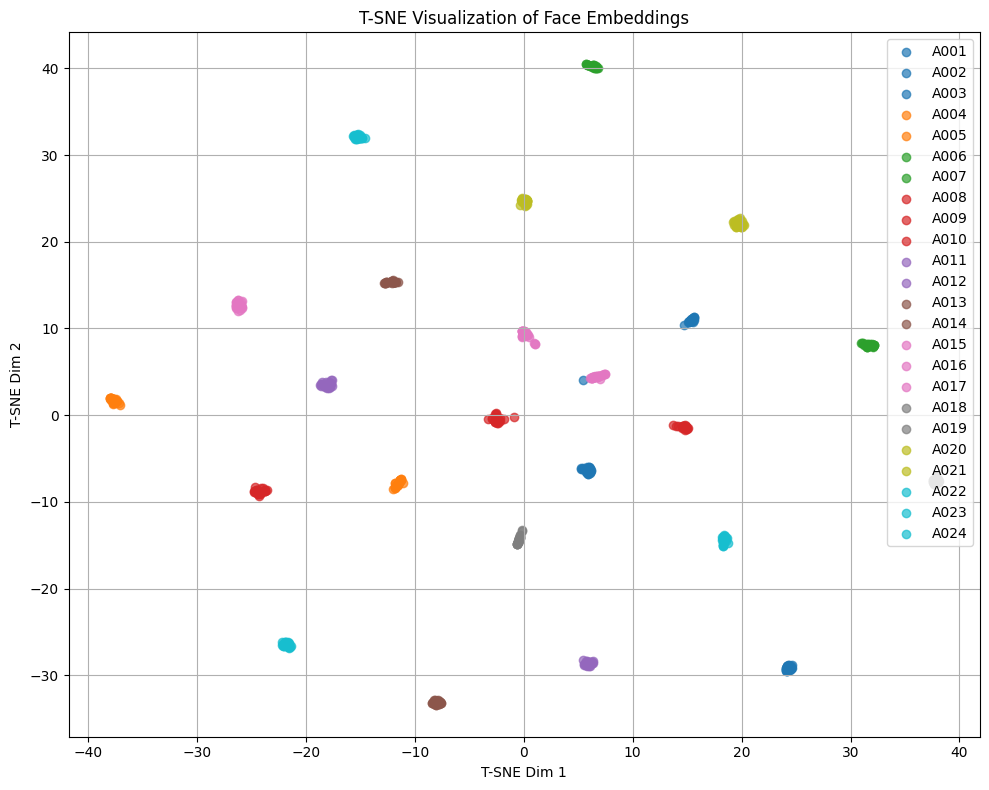

In [28]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# --- 1. Load mô hình TFLite ---
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/face_recognition_model_compatible.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# --- 2. Tiền xử lý ---
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    img = np.array(img).astype(np.float32) / 255.0
    return np.expand_dims(img, axis=0)

def get_embedding(image):
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    return interpreter.get_tensor(output_details[0]['index'])[0]

# --- 3. Trích xuất tất cả embedding ---
embeddings = []
labels = []

test_dir = '/kaggle/input/face-data-200-augmentation/200/test'

for label in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, label)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image = preprocess_image(img_path)
        emb = get_embedding(image)
        embeddings.append(emb)
        labels.append(label)

embeddings = np.array(embeddings)

# --- 4. Giảm chiều bằng T-SNE ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# --- 5. Vẽ biểu đồ ---
plt.figure(figsize=(10, 8))
unique_labels = sorted(set(labels))
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(
        embeddings_2d[idxs, 0],
        embeddings_2d[idxs, 1],
        label=label,
        alpha=0.7,
        color=colors(i)
    )

plt.legend()
plt.title("T-SNE Visualization of Face Embeddings")
plt.xlabel("T-SNE Dim 1")
plt.ylabel("T-SNE Dim 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_face_embeddings.png", dpi=300)
plt.show()


In [29]:
# Lưu thông tin models và results
model_info = {
    'model_architecture': 'MobileNetV2 + ArcFace',
    'embedding_size': EMBEDDING_SIZE,
    'num_classes': num_classes,
    'student_names': student_names,
    'label_classes': label_encoder.classes_.tolist(),
    'training_results': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1)
    }
}

with open('model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, ensure_ascii=False, indent=2)

In [30]:
print("✅ Các file đã được lưu:")
print("- face_recognition_training_model.h5 (Training model với ArcFace)")
print("- face_recognition_inference_model.h5 (Inference model để extract embedding)")
print("- face_recognition_model.tflite (TensorFlow Lite model)")
print("- model_info.json (Thông tin model và kết quả)")

✅ Các file đã được lưu:
- face_recognition_training_model.h5 (Training model với ArcFace)
- face_recognition_inference_model.h5 (Inference model để extract embedding)
- face_recognition_model.tflite (TensorFlow Lite model)
- model_info.json (Thông tin model và kết quả)
